# Marketing Mix Model - Prior Selection in Uncertain Spaces
A procedure outlining how to determine appropriate priors given performance history and industry uncertainty.  

In [1]:
!pip install --upgrade google-meridian[colab,and-cuda]

In [2]:
import arviz as az
import IPython

from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import formatter
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.data import data_frame_input_data_builder
from meridian.data import test_utils
from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from datetime import datetime, timedelta

import tensorflow as tf
import tensorflow_probability as tfp

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Marketing Science Portfolio/MMM-bayesian-prior-analysis/data/MMM_Data.csv', parse_dates=["DATE"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))

The loaded data is not my own and was exposed in a discovered GitHub repository. For the purposes of this study I have removed certain identifiable variables, and I will not be printing the data directly. I have no prior knowledge of the industry in which this adspend data originates from but it does follow a typical commercial seasonal pattern, with higher revenue during special sale periods (holiday seasons) and a drop in revenue experienced in the summer months.

## Target Variables

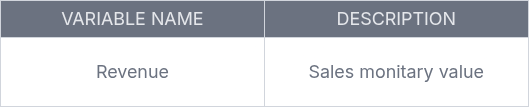

## Advertising Spend Features

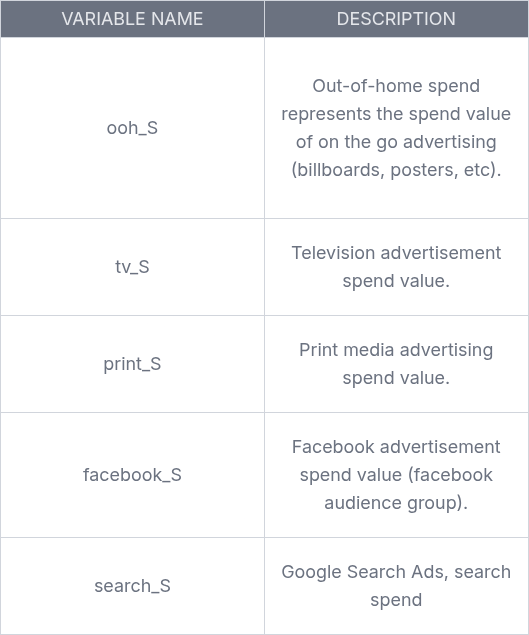

## Performance Variables

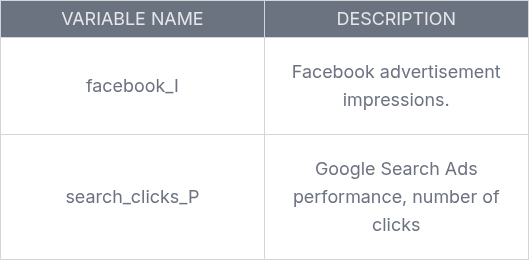

In order to determine the channel priors, I will examine the spend performances focusing on the first 75% of the provided data and test our resulting models with the last 25%.

_This is a common split for developing models for temporal data._

Before we do that let's see how much data we are working with:

In [4]:
# How many weeks are in the data?
print(f"{len(data)} weeks ({data['DATE'].min()} to {data['DATE'].max()})")

208 weeks (2015-11-23 00:00:00 to 2019-11-11 00:00:00)


with 208 weeks or 4 years of data, there is a decent amount of information we can work with. With 75% of the data, prior distributions will be determined with utilizing 3 years of data and the testing sequence will involve one year of data.

According to Google's Meridian documentation which discusses the [amount of data needed](https://developers.google.com/meridian/docs/advanced-modeling/amount-data-needed) [1], we are in good standing for a national model considering the extent of the weekly data we are working with. Google's documentation explicitly states that two years' worth of weekly data consisting of 104 data points is not enough and represents a low sample-size scenario - _adding more data above this scenario will reduce the variance in inference, but might make the inference less relevant._

**This last point is why I have decided to utilize the first 3 years of data for inferential purposes.**

In [5]:
train_weeks = int(len(data) * 0.75)
test_weeks = len(data) - train_weeks

train_data = data.iloc[:train_weeks].copy()
test_data = data.iloc[train_weeks:].copy()

print(f"Training data: {len(train_data)} weeks ({train_data['DATE'].min()} to {train_data['DATE'].max()})")
print(f"Testing data: {len(test_data)} weeks ({test_data['DATE'].min()} to {test_data['DATE'].max()})")

Training data: 156 weeks (2015-11-23 00:00:00 to 2018-11-12 00:00:00)
Testing data: 52 weeks (2018-11-19 00:00:00 to 2019-11-11 00:00:00)


Now that the data split has been determined we can begin the analysis. Starting with the media channel adstock.

In [6]:
media_channels = ['tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']

The following section will focus on determining industry benchmarks and literature-based _AdStock_ ranges.

# References



[1] “Amount of data needed | Meridian | Google for Developers.” Accessed: Aug. 07, 2025. [Online]. Available: https://developers.google.com/meridian/docs/advanced-modeling/amount-data-needed
